# Error Calculation
## The main purpose of this notebook is to experiment with different methods of caluclating the error between the signal and the reconstructed signal
Rather than training new models this work can just rely on previous trained models to see what effect it has on existing results

In [139]:
# Import required libraries
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model, load_model
import seaborn as sns
import datetime
import os.path

from utils import *
from importlib import reload

In [4]:
# Import preprocessed data
file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/datasets/'
DIAGRAM_FILE_PATH = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/'

In [5]:
file_version = 'ws100num2derFalse'
sensors = ['left_angle', 'right_angle'] #'back_angle', 
file_name = f'{file_version}-control.npy'
path = file_path + file_name
trainX = np.load(path)
print(f'Number of control training samples: {trainX.shape}')

Number of control training samples: (3868, 100, 2)


In [6]:
# Retrieve data and place with pd dataframe
patient_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/datasets/patient/patient_data.csv'
dataframe = pd.read_csv(patient_file_path, parse_dates=['datetime'])
df = dataframe.loc[:,sensors]
df.loc[:,'Date'] = pd.to_datetime(dataframe.loc[:,'datetime'])

# Split test and train data
train, test = df.loc[df['Date'] <= '2011-12-01 11:38:00'], df.loc[df['Date'] > '2011-12-01 11:38:00']
train

,left_angle,right_angle,Date
0,0.572584,0.215395,2011-12-01 11:04:05.000
1,0.568733,0.200416,2011-12-01 11:04:05.050
2,0.564883,0.200416,2011-12-01 11:04:05.100
3,0.557181,0.201110,2011-12-01 11:04:05.150
4,0.541779,0.200416,2011-12-01 11:04:05.200
...,...,...,...
38182,0.276088,0.527046,2011-12-01 11:35:54.100
38183,0.276088,0.525659,2011-12-01 11:35:54.150
38184,0.276088,0.524272,2011-12-01 11:35:54.200
38185,0.276088,0.524272,2011-12-01 11:35:54.250


In [7]:
compress = 0.4
units_one = int(trainX.shape[1] * trainX.shape[2] * compress)
units_two = int(units_one * 0.5)
print(f"1st layer units: {units_one}, 2nd layer units: {units_two}")

1st layer units: 80, 2nd layer units: 40


In [8]:
two_time_code = '110000_0420'
two_model_file = f'{two_time_code}-model.h5'
two_model_file

'110000_0420-model.h5'

In [9]:
# Fit the model
if os.path.isfile(two_model_file):
    two_model = load_model(two_model_file)
    print(f"Loaded {two_model_file}")

    two_model.summary()
    for layer in two_model.layers:
        print(layer.input_shape)
else:
    # Define AutoEncoder architecture
    two_model = Sequential()
    # Encoder
    two_model.add(LSTM(units_one, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    two_model.add(Dropout(rate=0.2))
    two_model.add(LSTM(units_two, return_sequences=False))
    # Bridge
    two_model.add(RepeatVector(trainX.shape[1]))
    #Decoder
    two_model.add(LSTM(units_two, return_sequences=True))
    two_model.add(LSTM(units_one, return_sequences=True))
    two_model.add(Dropout(rate=0.2))
    two_model.add(TimeDistributed(Dense(trainX.shape[2])))
    two_model.compile(optimizer='adam', loss='mae')

    two_model.summary()
    for layer in two_model.layers:
        print(layer.input_shape)

    callback = EarlyStopping(monitor='loss', patience=2, min_delta=1e-3)
    two_history = two_model.fit(trainX, trainX, epochs=50, batch_size=32, validation_split=0.1, verbose=1, callbacks=[callback])

    # Show the history of loss
    plt.figure(figsize=(16, 8))
    plt.plot(two_history.history['loss'], label='Training loss')
    plt.plot(two_history.history['val_loss'], label='Validation loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Augmented Model Training - {two_time_code}")
    plt.legend()

    diag_file_name = f'training-{two_time_code}.png'
    plt.savefig(f'{DIAGRAM_FILE_PATH}{diag_file_name}')

    
    two_model.save(two_model_file)
    print(f"Saved as {two_model_file}")

Loaded 110000_0420-model.h5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100, 80)           26560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 80)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 40)                19360     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 100, 40)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100, 40)           12960     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 80)           38720     
_________________________________________________________________
dropout_3 (Dropout)       

In [111]:
# Load just the patient data
file_patient = f'{file_version}-patient-shaved.npy'
path = file_path + file_patient
patientX = np.load(path)
print(f'Number of patient testing samples: {patientX.shape}')

Number of patient testing samples: (38087, 100, 2)


In [112]:
patientPredict = two_model.predict(patientX)

In [113]:
no_feats = trainX.shape[2]
seq_size = trainX.shape[1]
example = 10

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

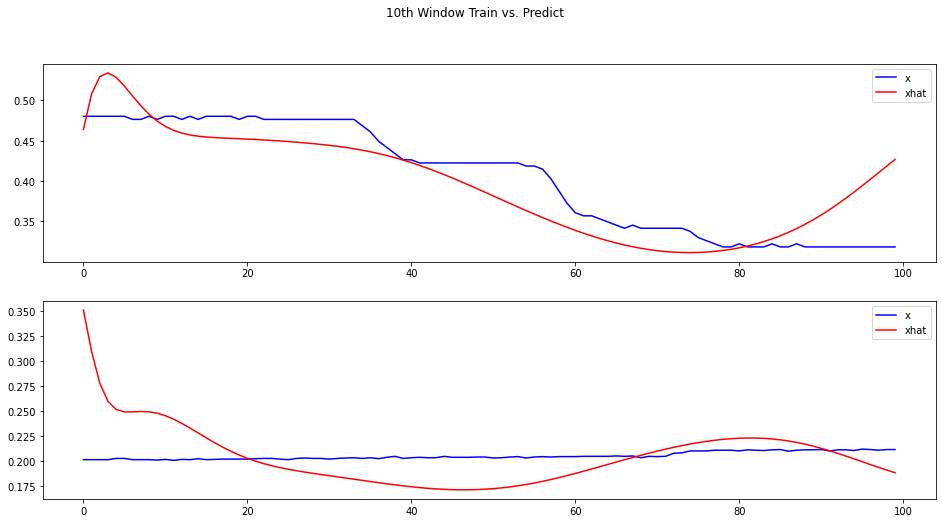

In [114]:
example_plot(example, no_feats, seq_size, patientX, patientPredict)

## Mean Absolute Error: The default of what has been done until now

In [115]:
MAE = error_computation(patientX, patientPredict, 'MAE')
MAE.shape

(38087, 2)

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

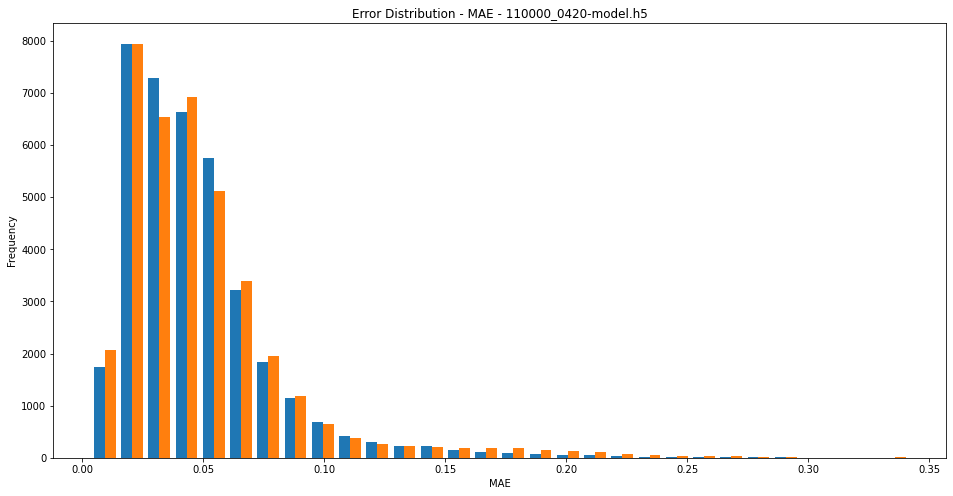

In [116]:
error_hist_and_save(MAE, 'MAE', two_model_file, DIAGRAM_FILE_PATH)

In [117]:
pct = 0.8
thresh = fixed_thresh(pct, MAE, len(train[seq_size:]))
thresh

array([0.27305124, 0.27305124, 0.27305124, ..., 0.27305124, 0.27305124,
       0.27305124])

In [118]:
anomaly_frame = anomaly_df(train, seq_size, MAE, thresh)
anomaly_frame.head()

,left_angle,right_angle,Date,error,thresh,anomaly
100,0.318444,0.211650,2011-12-01 11:04:10.000,0.029472,0.273051,False
101,0.318444,0.210264,2011-12-01 11:04:10.050,0.030062,0.273051,False
102,0.318444,0.211373,2011-12-01 11:04:10.100,0.030414,0.273051,False
103,0.318444,0.211373,2011-12-01 11:04:10.150,0.030722,0.273051,False
104,0.318444,0.210680,2011-12-01 11:04:10.200,0.030485,0.273051,False


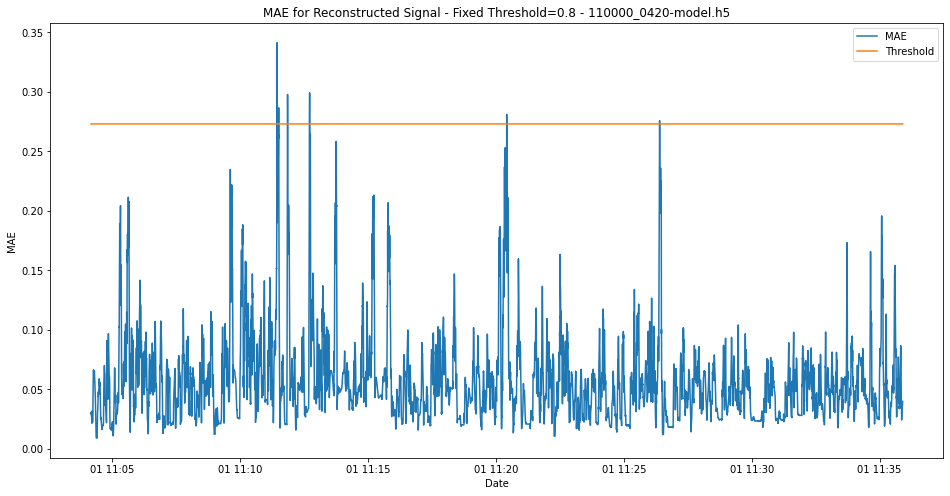

In [119]:
anomalies, _ = error_vs_thresh_plot_and_save(anomaly_frame, pct, 'MAE', two_model_file, DIAGRAM_FILE_PATH)

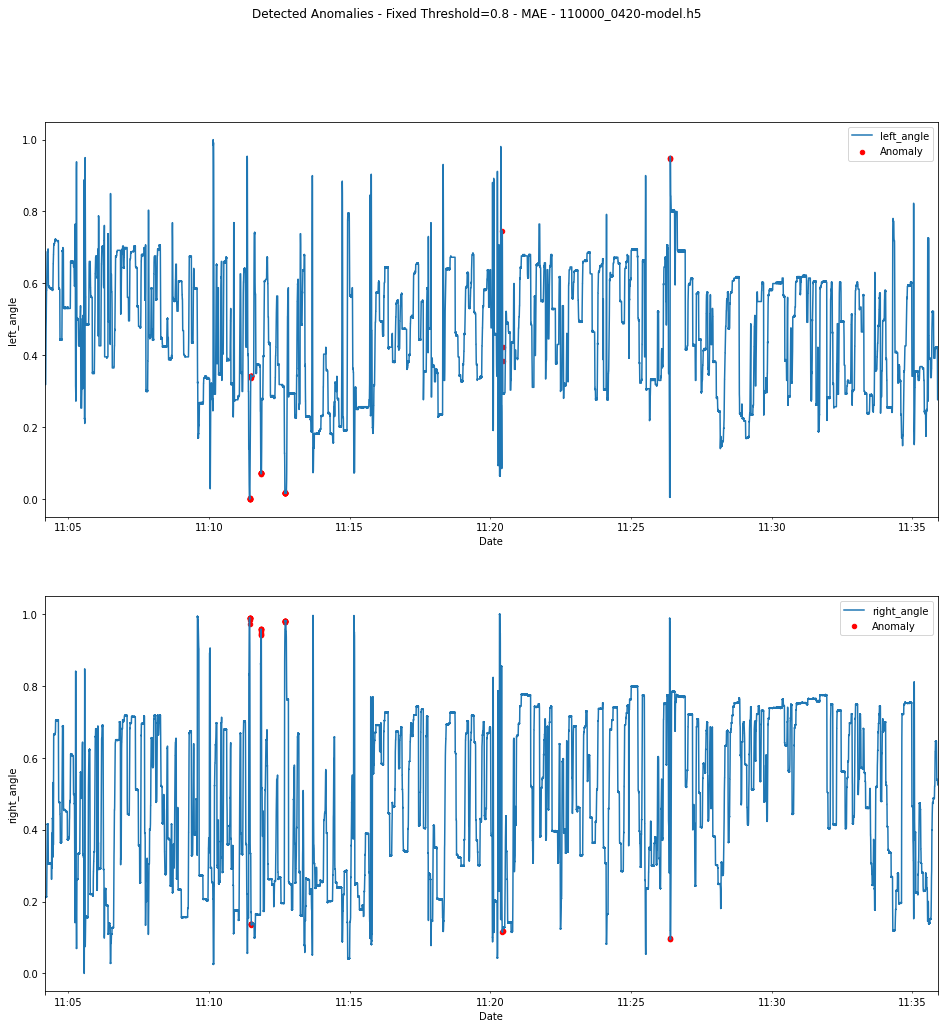

In [120]:
detect_anom_plot_and_save(no_feats, sensors, anomaly_frame, anomalies, pct, 'MAE', two_model_file, DIAGRAM_FILE_PATH)

## Area Difference

In [140]:
%reload_ext autoreload
%aimport utils

In [121]:
area_error = error_computation(patientX, patientPredict, mode='Area')
area_error.shape

(38087, 2)

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

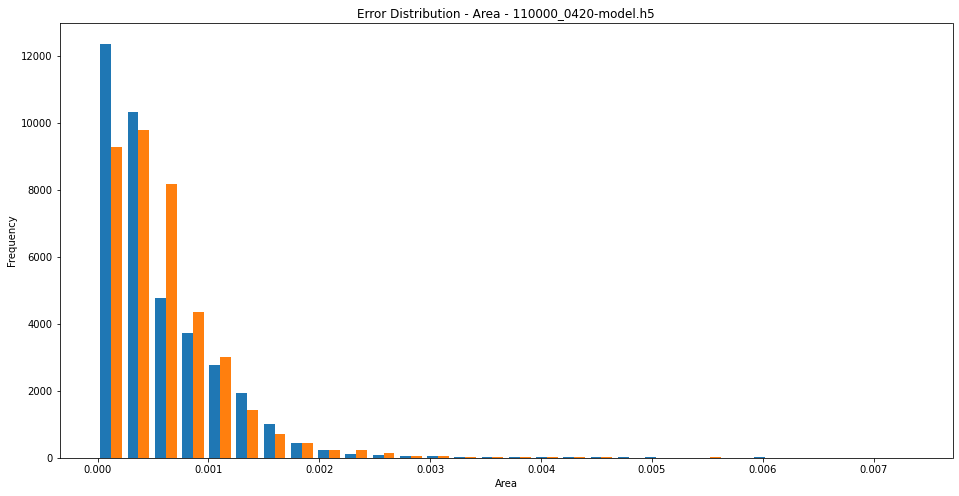

In [122]:
error_hist_and_save(area_error, 'Area', two_model_file, DIAGRAM_FILE_PATH)

In [123]:
pct = 0.8
thresh = fixed_thresh(pct, area_error, len(train[seq_size:]))
thresh

array([0.00589483, 0.00589483, 0.00589483, ..., 0.00589483, 0.00589483,
       0.00589483])

In [124]:
anomaly_frame = anomaly_df(train, seq_size, area_error, thresh)
anomaly_frame.head()

,left_angle,right_angle,Date,error,thresh,anomaly
100,0.318444,0.211650,2011-12-01 11:04:10.000,0.000211,0.005895,False
101,0.318444,0.210264,2011-12-01 11:04:10.050,0.000198,0.005895,False
102,0.318444,0.211373,2011-12-01 11:04:10.100,0.000186,0.005895,False
103,0.318444,0.211373,2011-12-01 11:04:10.150,0.000174,0.005895,False
104,0.318444,0.210680,2011-12-01 11:04:10.200,0.000164,0.005895,False


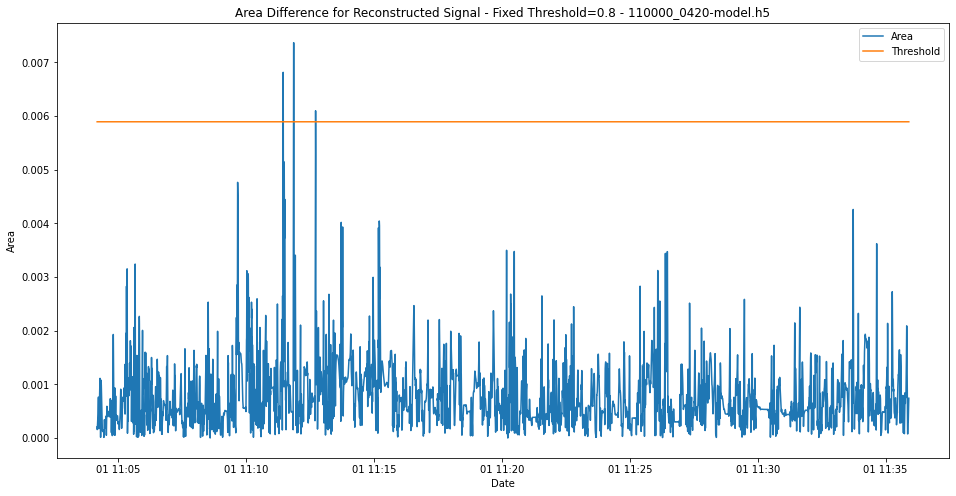

In [125]:
anomalies, _ = error_vs_thresh_plot_and_save(anomaly_frame, pct, 'Area', two_model_file, DIAGRAM_FILE_PATH)

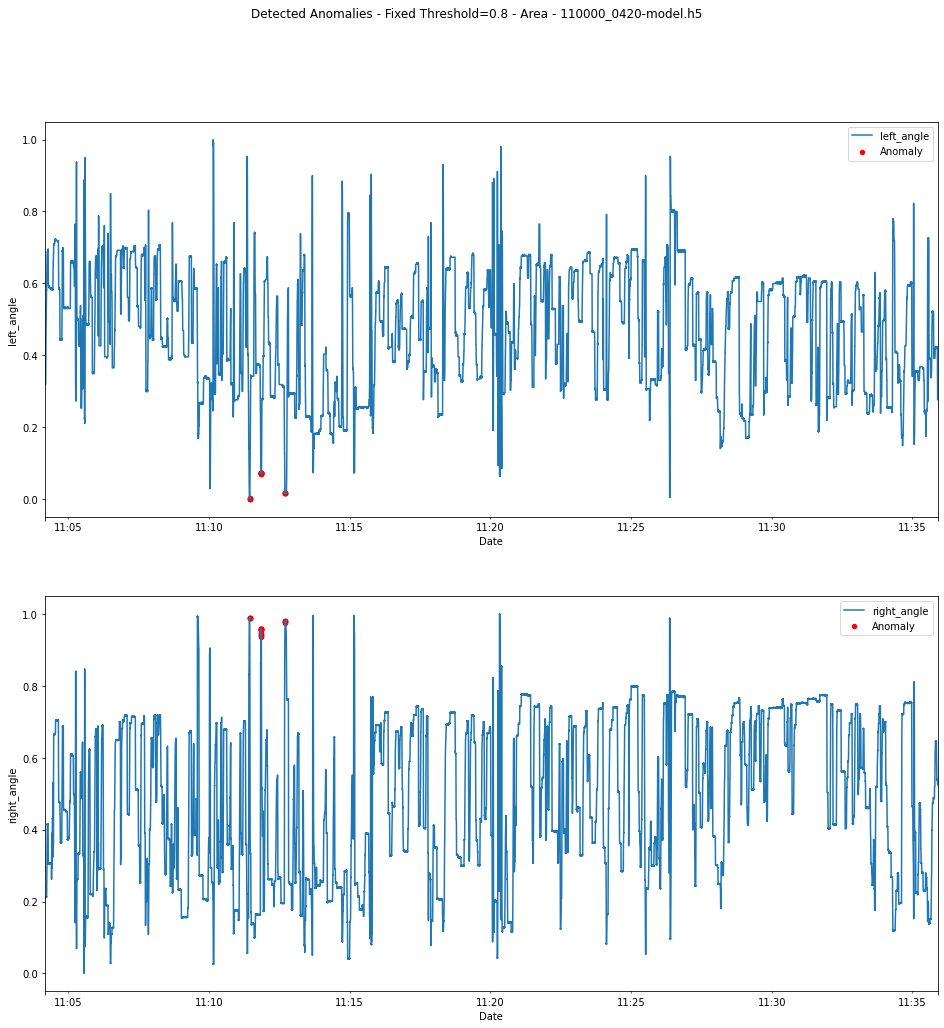

In [126]:
detect_anom_plot_and_save(no_feats, sensors, anomaly_frame, anomalies, pct, 'Area', two_model_file, DIAGRAM_FILE_PATH)

## Dynamic Time Warping

In [159]:
%reload_ext autoreload
%aimport utils

In [160]:
# This takes a LONG TIME
DTW_error = error_computation(patientX, patientPredict, mode='DTW')
DTW_error.shape

100/38087
200/38087
300/38087
400/38087
500/38087
600/38087
700/38087
800/38087
900/38087
1000/38087
1100/38087
1200/38087
1300/38087
1400/38087
1500/38087
1600/38087
1700/38087
1800/38087
1900/38087
2000/38087
2100/38087
2200/38087
2300/38087
2400/38087
2500/38087
2600/38087
2700/38087
2800/38087
2900/38087
3000/38087
3100/38087
3200/38087
3300/38087
3400/38087
3500/38087
3600/38087
3700/38087
3800/38087
3900/38087
4000/38087
4100/38087
4200/38087
4300/38087
4400/38087
4500/38087
4600/38087
4700/38087
4800/38087
4900/38087
5000/38087
5100/38087
5200/38087
5300/38087
5400/38087
5500/38087
5600/38087
5700/38087
5800/38087
5900/38087
6000/38087
6100/38087
6200/38087
6300/38087
6400/38087
6500/38087
6600/38087
6700/38087
6800/38087
6900/38087
7000/38087
7100/38087
7200/38087
7300/38087
7400/38087
7500/38087
7600/38087
7700/38087
7800/38087
7900/38087
8000/38087
8100/38087
8200/38087
8300/38087
8400/38087
8500/38087
8600/38087
8700/38087
8800/38087
8900/38087
9000/38087
9100/38087
9200/380

(38087, 2)

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

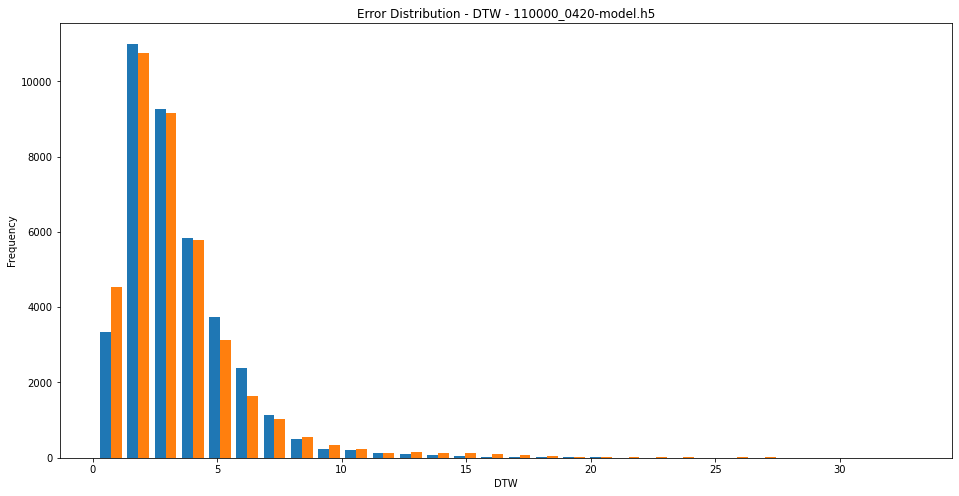

In [161]:
error_hist_and_save(DTW_error, 'DTW', two_model_file, DIAGRAM_FILE_PATH)

In [162]:
pct = 0.8
thresh = fixed_thresh(pct, DTW_error, len(train[seq_size:]))
thresh

array([26.39849029, 26.39849029, 26.39849029, ..., 26.39849029,
       26.39849029, 26.39849029])

In [163]:
anomaly_frame = anomaly_df(train, seq_size, DTW_error, thresh)
anomaly_frame.head()

,left_angle,right_angle,Date,error,thresh,anomaly
100,0.318444,0.211650,2011-12-01 11:04:10.000,1.539073,26.39849,False
101,0.318444,0.210264,2011-12-01 11:04:10.050,1.843594,26.39849,False
102,0.318444,0.211373,2011-12-01 11:04:10.100,1.880023,26.39849,False
103,0.318444,0.211373,2011-12-01 11:04:10.150,1.914807,26.39849,False
104,0.318444,0.210680,2011-12-01 11:04:10.200,1.955649,26.39849,False


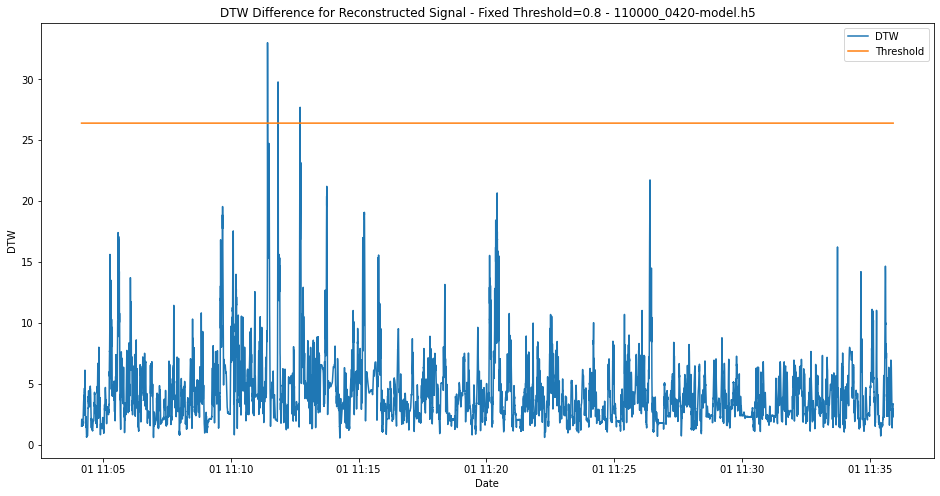

In [164]:
anomalies, _ = error_vs_thresh_plot_and_save(anomaly_frame, pct, 'DTW', two_model_file, DIAGRAM_FILE_PATH)

Exception ignored in: <function tqdm.__del__ at 0x15361a4c0>
Traceback (most recent call last):
  File "/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/tqdm/std.py", line 1145, in __del__
    self.close()
  File "/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='success', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


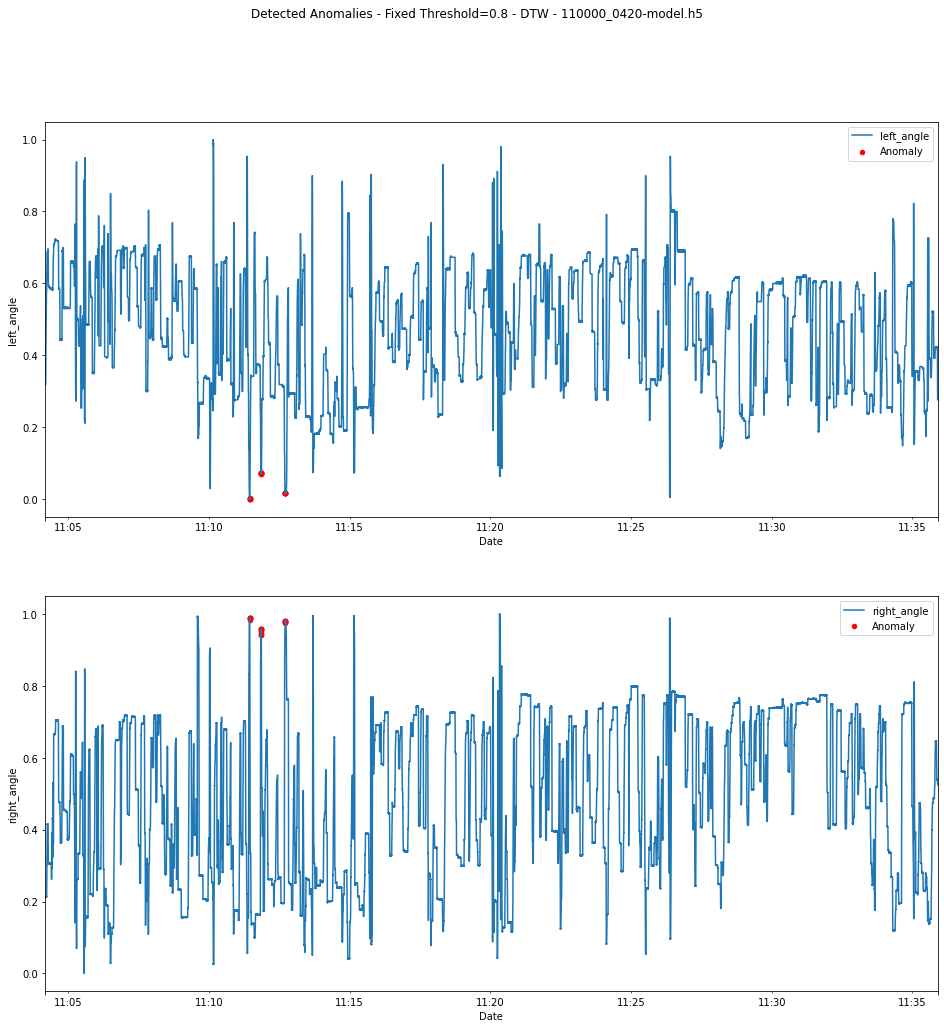

In [165]:
detect_anom_plot_and_save(no_feats, sensors, anomaly_frame, anomalies, pct, 'DTW', two_model_file, DIAGRAM_FILE_PATH)